# Compare today's matter power spectra for PM, BullFrog 🐸 and COLA

Mayeul Aubin, Tristan Hoellinger<br/>
Institut d'Astrophysique de Paris</br>
tristan.hoellinger@iap.fr

Plot today's matter power spectra for PM, BullFrog 🐸 and COLA, given pre-computed simulations.

In [1]:
import pickle
import numpy as np
from pysbmy.fft import read_FourierGrid
from pysbmy.correlations import get_autocorrelation

from tools import read_field
from plot_utils import *

## Set up the environment

In [2]:
run_id = "run1"

workdir = (
    f"/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests_parser/params/{run_id}/"
)
simdir = f"/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests_parser/sims/{run_id}/"

## Load data and plot

In [3]:
with open(workdir + "params.pkl", "rb") as f:
    params = pickle.load(f)

N = params["N"]
L = params["L"]
nsteps_pm_list = params["nsteps_pm"]
nsteps_cola_list = params["nsteps_cola"]
nsteps_bullfrog_list = params["nsteps_bullfrog"]
print(N, L, nsteps_pm_list, nsteps_cola_list, nsteps_bullfrog_list)

128 200 [50] [2, 5, 10] [2, 5, 10]


### Plot the evolved dark matter density fields

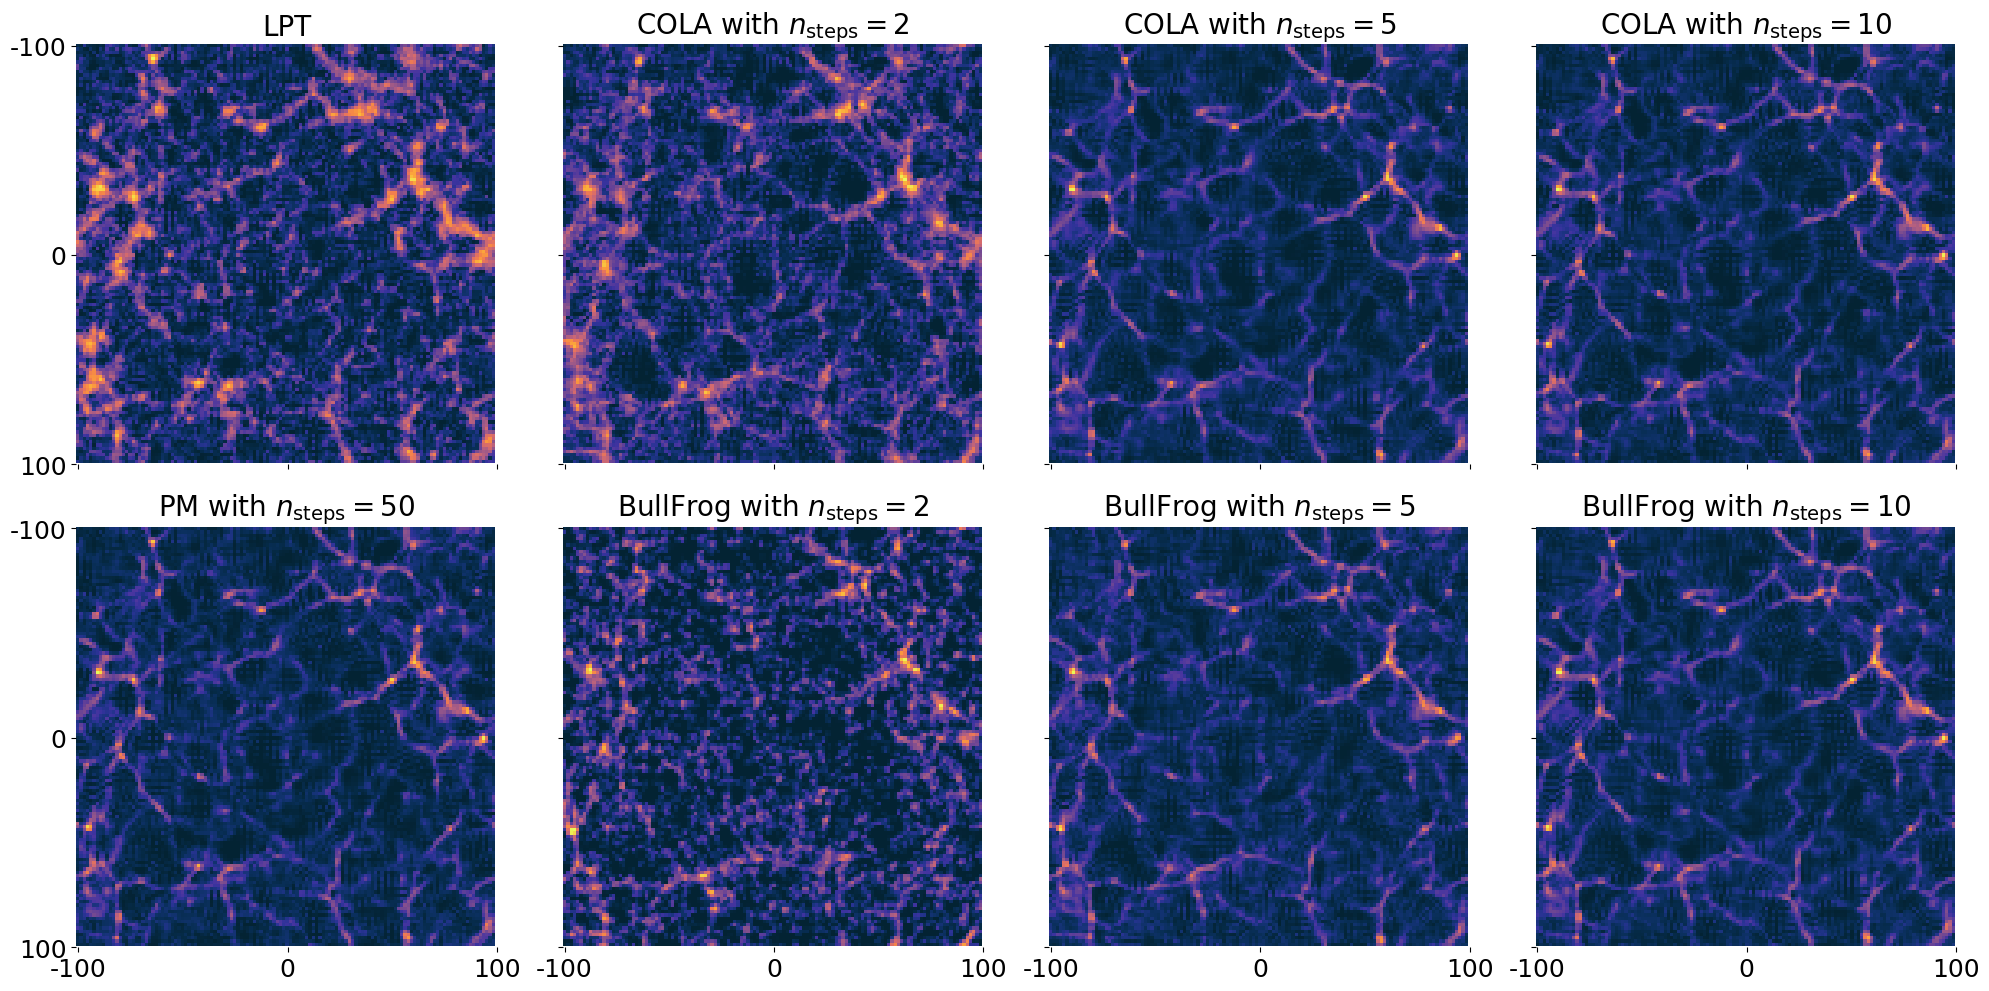

In [4]:
slice_ijk = (N // 2, slice(None), slice(None))
DELTA_LPT = read_field(simdir + "lpt_density.h5").data[slice_ijk]

all_nsteps = sorted(list(set(nsteps_cola_list + nsteps_bullfrog_list)))[:4]

ncols = len(all_nsteps) + 1
nrows = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows), sharex=True, sharey=True)
axs[0, 0].imshow(np.log(2 + DELTA_LPT), cmap=cmap)
axs[0, 0].set_title("LPT", fontsize=fs_titles)
DELTA_PM = read_field(simdir + f"nsteps{max(nsteps_pm_list)}_final_density_pm.h5").data[slice_ijk]
axs[1, 0].imshow(np.log(2 + DELTA_PM), cmap=cmap)
axs[1, 0].set_title(f"PM with $n_\\mathrm{{steps}}={max(nsteps_pm_list)}$", fontsize=fs_titles)
for i, nsteps in enumerate(all_nsteps):
    if nsteps in nsteps_cola_list:
        DELTA_COLA = read_field(simdir + f"nsteps{nsteps}_final_density_cola.h5").data[slice_ijk]
        axs[0, i + 1].imshow(np.log(2 + DELTA_COLA), cmap=cmap)
        axs[0, i + 1].set_title(f"COLA with $n_\\mathrm{{steps}}={nsteps}$", fontsize=fs_titles)
    if nsteps in nsteps_bullfrog_list:
        DELTA_BULLFROG = read_field(simdir + f"nsteps{nsteps}_final_density_bullfrog.h5").data[
            slice_ijk
        ]
        axs[1, i + 1].imshow(np.log(2 + DELTA_BULLFROG), cmap=cmap)
        axs[1, i + 1].set_title(
            f"BullFrog with $n_\\mathrm{{steps}}={nsteps}$", fontsize=fs_titles
        )
for ax in axs.flatten():
    ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
for ax in axs[:, 0]:
    ax.set_yticks([0, N // 2, N])
    ax.set_yticklabels([f"{-L/2:.0f}", "0", f"{L/2:.0f}"], fontsize=fs)
for ax in axs[1, :]:
    ax.set_xticks([0, N // 2, N])
    ax.set_xticklabels([f"{-L/2:.0f}", "0", f"{L/2:.0f}"], fontsize=fs)
for i in range(nrows):
    for j in range(ncols):
        if axs[i, j].get_title() == "":
            axs[i, j].axis("off")
plt.tight_layout()
plt.show()

### Compute and plot the power spectra of the evolved dark matter fields

In [5]:
G = read_FourierGrid(simdir + "input_ss_k_grid.h5")
k = G.k_modes
print(k.shape)
AliasingCorr = False

DELTA = read_field(simdir + "initial_density.h5")
Pk_INI, Vk_INI = get_autocorrelation(DELTA, G, False)
Pk_INI, Vk_INI = Pk_INI[1:], Vk_INI[1:]
Sk_INI = np.sqrt(Vk_INI)

DELTA = read_field(simdir + "lpt_density.h5")
Pk_LPT, Vk_LPT = get_autocorrelation(DELTA, G, AliasingCorr)
Pk_LPT, Vk_LPT = Pk_LPT[1:], Vk_LPT[1:]
Sk_LPT = np.sqrt(Vk_LPT)

Pk_PM_list = []
Sk_PM_list = []
for nsteps in nsteps_pm_list:
    DELTA = read_field(simdir + f"nsteps{nsteps}_final_density_pm.h5")
    Pk_PM, Vk_PM = get_autocorrelation(DELTA, G, AliasingCorr)
    Pk_PM, Vk_PM = Pk_PM[1:], Vk_PM[1:]
    Sk_PM = np.sqrt(Vk_PM)
    Pk_PM_list.append(Pk_PM)
    Sk_PM_list.append(Sk_PM)

Pk_ref = Pk_PM_list[-1]

Pk_COLA_list = []
Sk_COLA_list = []
for nsteps in nsteps_cola_list:
    DELTA = read_field(simdir + f"nsteps{nsteps}_final_density_cola.h5")
    Pk_COLA, Vk_COLA = get_autocorrelation(DELTA, G, AliasingCorr)
    Pk_COLA, Vk_COLA = Pk_COLA[1:], Vk_COLA[1:]
    Sk_COLA = np.sqrt(Vk_COLA)
    Pk_COLA_list.append(Pk_COLA)
    Sk_COLA_list.append(Sk_COLA)

Pk_BULLFROG_list = []
Sk_BULLFROG_list = []
for nsteps in nsteps_bullfrog_list:
    DELTA = read_field(simdir + f"nsteps{nsteps}_final_density_bullfrog.h5")
    Pk_BULLFROG, Vk_BULLFROG = get_autocorrelation(DELTA, G, AliasingCorr)
    Pk_BULLFROG, Vk_BULLFROG = Pk_BULLFROG[1:], Vk_BULLFROG[1:]
    Sk_BULLFROG = np.sqrt(Vk_BULLFROG)
    Pk_BULLFROG_list.append(Pk_BULLFROG)
    Sk_BULLFROG_list.append(Sk_BULLFROG)

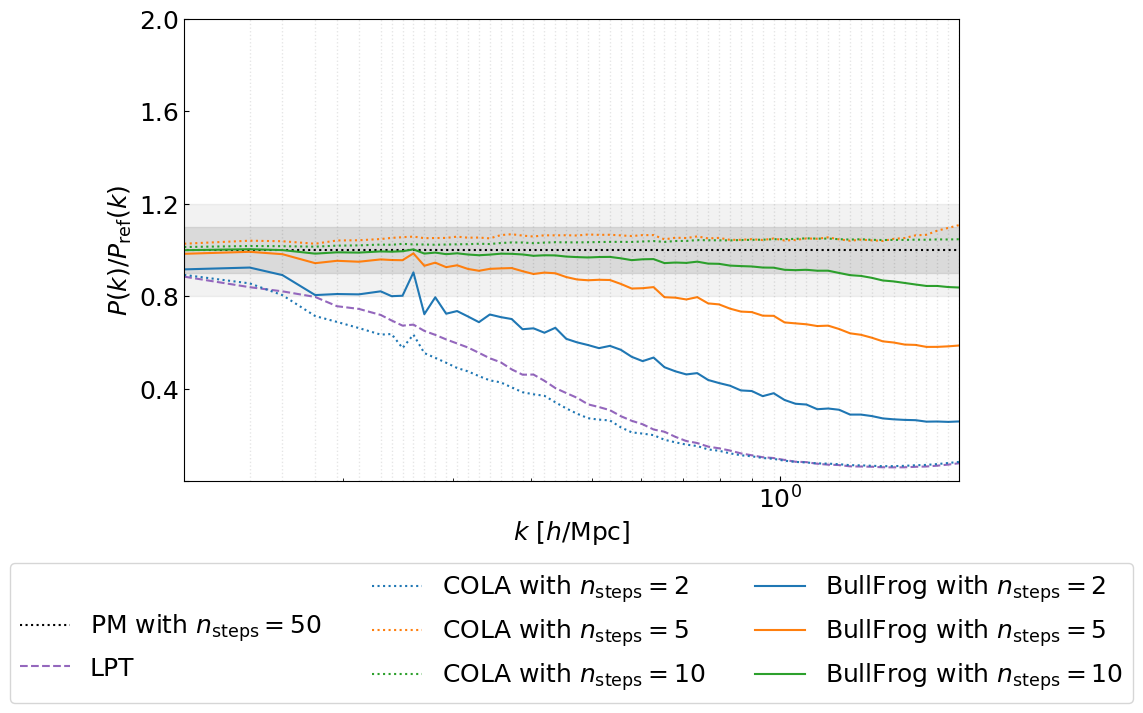

In [7]:
common_nsteps = sorted(set(nsteps_cola_list).intersection(nsteps_bullfrog_list))
# common_nsteps = [nsteps for nsteps in common_nsteps if nsteps > 2]  # filter out first spectra
nlines = len(common_nsteps) + 2

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xscale("log")
k = G.k_modes[1:]
ax.set_xlim([k.min(), k.max()])
ax.set_ylim([0, 2])  # to be adjusted depending on the setup
bnd1 = 0.1  # to be adjusted depending on the setup
bnd2 = 0.2  # to be adjusted depending on the setup

label_ref = f"PM with $n_\\mathrm{{steps}}={max(nsteps_pm_list)}$"
line1 = ax.plot([1e-3, 1e1], [1, 1], color="black", linestyle=":", label=label_ref)
line2 = ax.plot(
    k, Pk_LPT / Pk_ref, label="LPT", color=cols[len(common_nsteps) + 1], linestyle="--"
)
# line3 = ax.plot(k, Pk_INI / Pk_ref, label="ICs", color=cols[len(common_nsteps)], linestyle="--")
line3 = None  # uncomment to hide ICs
for i, nsteps in enumerate(nsteps_pm_list[:-1]):
    ax.plot(
        k,
        Pk_PM_list[i] / Pk_ref,
        label=f"PM with $n_\\mathrm{{steps}}={nsteps}$",
        linestyle="--",
        color=cols[i],
    )
for i, nsteps in enumerate(common_nsteps):
    ax.plot(
        k,
        Pk_COLA_list[i] / Pk_ref,
        label=f"COLA with $n_\\mathrm{{steps}}={nsteps}$",
        linestyle=":",
        color=cols[i],
    )
for i, nsteps in enumerate(common_nsteps):
    ax.plot(
        k,
        Pk_BULLFROG_list[i] / Pk_ref,
        label=f"BullFrog with $n_\\mathrm{{steps}}={nsteps}$",
        linestyle="-",
        color=cols[i],
    )

ax.axhspan(1 - bnd1, 1 + bnd1, color="grey", alpha=0.2)
ax.axhspan(1 - bnd2, 1 + bnd2, color="grey", alpha=0.1)

# ax.grid(alpha=0.3)
for i in range(1, len(k)):
    ax.axvline(k[i], color="black", linestyle=":", linewidth=1, alpha=0.1)
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
ax.set_xlabel("$k$ [$h/\\mathrm{Mpc}$]", fontsize=fs)
ax.set_ylabel("$P(k)/P_\\mathrm{ref}(k)$", fontsize=fs)
ax.tick_params(which="both", direction="in")
ax.tick_params(axis="both", which="major", labelsize=fs)
ax.tick_params(axis="both", which="minor", labelsize=fs)
if line3 is None:
    empty_patch = mpatches.Patch(color="none", label="")
    handles, labels = plt.gca().get_legend_handles_labels()
    handles = [empty_patch, *handles]
    labels = ["", *labels]
    plt.legend(
        handles,
        labels,
        loc="upper center",
        ncol=3,
        bbox_to_anchor=(0.5, -0.15),
        fontsize=fs,
    )
else:
    plt.legend(loc="upper center", ncol=3, bbox_to_anchor=(0.5, -0.15), fontsize=fs)

plt.show()